In [1]:
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm
import sklearn.metrics as skmetrics
from prophet import Prophet
from statsmodels.tsa.api import VAR # easier for order selection
from statsmodels.tsa.statespace.varmax import VARMAX # easier for forecasting


import warnings                               
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('train.csv')
#df['Datetime'] = pd.to_datetime(df['Datetime'])
df

,Datetime,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
0,2018-01-01 06:20:00+00:00,26.212347,28.696304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.00,3.976499,NaN,NaN,252.00,3.042750
1,2018-01-01 06:40:00+00:00,59.632658,29.052567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.00,11.091660,NaN,NaN,255.00,3.424814
2,2018-01-01 06:50:00+00:00,40.889650,28.984758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,264.75,4.234497,NaN,NaN,264.75,3.507172
3,2018-01-01 10:40:00+00:00,34.398111,30.282058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,283.75,5.347792,NaN,NaN,283.75,3.442212
4,2018-01-01 12:00:00+00:00,29.797653,29.333519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274.00,6.022326,NaN,NaN,274.00,3.031363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77197,2020-03-15 23:10:00+00:00,272.852287,23.500851,43.740629,-0.524250,-0.108540,-0.108540,63.668076,56.801410,1029.697556,64.904780,64.000634,35.012077,35.406250,182.00,54.889963,9.243551,2.0,182.00,5.156629
77198,2020-03-15 23:20:00+00:00,295.675931,23.409183,43.529209,-0.684376,-0.168882,-0.168882,63.361840,56.551527,1032.996150,64.109157,63.189782,35.004216,35.280933,182.00,60.673948,9.269149,2.0,182.00,5.257433
77199,2020-03-15 23:30:00+00:00,295.127333,23.336964,43.331115,-0.743521,-0.292512,-0.292512,63.156279,56.393276,1031.935870,63.740245,62.798514,35.003815,35.140925,182.00,59.551241,9.252811,2.0,182.00,5.188531
77200,2020-03-15 23:40:00+00:00,342.942216,23.310323,43.169442,-0.955621,-0.516466,-0.516466,63.191997,56.273992,1047.165900,63.657965,62.699627,35.003815,35.093750,182.00,69.460091,9.385111,2.0,182.00,5.408458


In [3]:
df_train = pd.DataFrame()

In [4]:
df_alter = df.copy()
df_alter['Datetime'] = pd.to_datetime(df_alter['Datetime']).dt.date

In [5]:
df_train['Date'] = df_alter['Datetime'].unique()

In [6]:
df_train['mean_daily_power'] = np.array(df_alter.groupby('Datetime')['ActivePower'].mean())

In [7]:
df_train

,Date,mean_daily_power
0,2018-01-01,366.223561
1,2018-01-02,462.550740
2,2018-01-03,454.417752
3,2018-01-04,369.952190
4,2018-01-05,319.446595
...,...,...
729,2020-03-11,466.289248
730,2020-03-12,570.315539
731,2020-03-13,619.637333
732,2020-03-14,800.312824


In [8]:
change_columns = df_alter.columns[2:-1]

In [9]:
for column in change_columns:
    df_train[f'mean_{column}_daily'] = np.array(\
        df_alter.groupby('Datetime')[column].mean())

In [10]:
df_train

,Date,mean_daily_power,mean_AmbientTemperatue_daily,mean_BearingShaftTemperature_daily,mean_Blade1PitchAngle_daily,mean_Blade2PitchAngle_daily,mean_Blade3PitchAngle_daily,mean_GearboxBearingTemperature_daily,mean_GearboxOilTemperature_daily,mean_GeneratorRPM_daily,mean_GeneratorWinding1Temperature_daily,mean_GeneratorWinding2Temperature_daily,mean_HubTemperature_daily,mean_MainBoxTemperature_daily,mean_NacellePosition_daily,mean_ReactivePower_daily,mean_RotorRPM_daily,mean_TurbineStatus_daily,mean_WindDirection_daily
0,2018-01-01,366.223561,25.528849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,276.727612,74.042120,NaN,NaN,276.727612
1,2018-01-02,462.550740,25.357526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274.105603,93.555723,NaN,NaN,274.105603
2,2018-01-03,454.417752,24.379363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,286.369130,91.627843,NaN,NaN,286.369130
3,2018-01-04,369.952190,24.912347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,284.445471,74.360621,NaN,NaN,284.445471
4,2018-01-05,319.446595,23.535679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,292.013293,64.366148,NaN,NaN,292.013293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,2020-03-11,466.289248,28.276232,44.059155,0.482881,0.934002,0.934002,64.106761,56.921031,1163.017505,67.939614,67.174603,38.635532,39.955577,183.729298,71.852813,10.420975,2.030612,183.729298
730,2020-03-12,570.315539,29.094133,44.476550,1.206977,1.629283,1.629283,64.051326,56.194520,1217.638162,70.008635,69.288543,39.978688,40.757739,180.773250,84.040654,10.931663,2.033333,180.773250
731,2020-03-13,619.637333,30.088163,45.903233,2.168904,2.609776,2.609776,65.348205,57.663415,1213.959374,72.745844,72.096953,39.562485,41.600482,187.621975,99.693231,10.884414,2.059259,187.621975
732,2020-03-14,800.312824,29.395626,45.924987,3.361067,3.771943,3.771943,65.975734,57.703463,1283.600520,79.347426,78.702074,39.610160,41.525481,177.635623,141.418250,11.506644,2.032787,177.635623


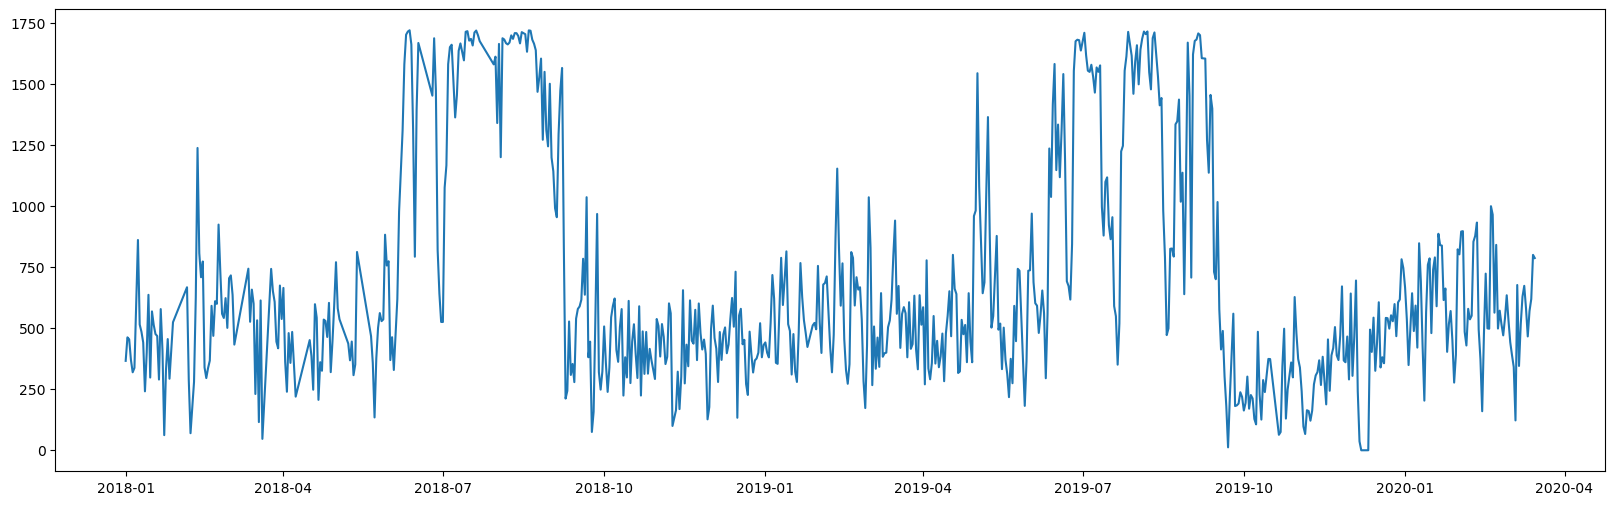

In [59]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(df_train['Date'], df_train['mean_daily_power'])
plt.show()

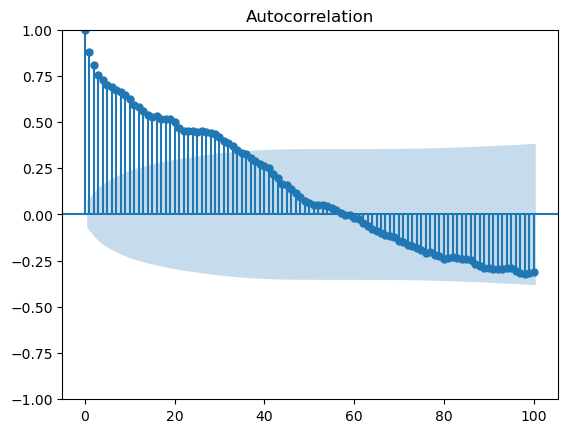

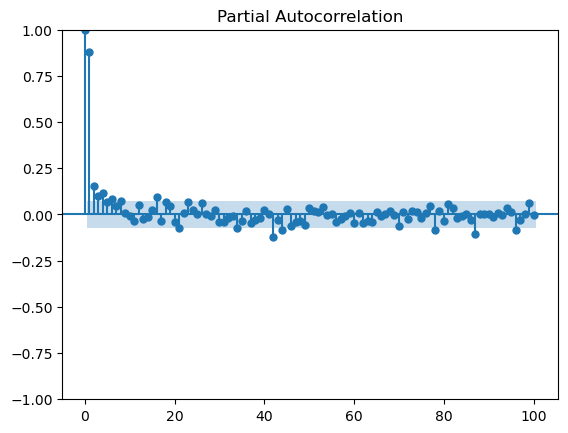

In [63]:
plot_acf(df_train['mean_daily_power'], lags=100)
plt.show()
plot_pacf(df_train['mean_daily_power'], lags=100)
plt.show()

In [14]:
dftest = adfuller(df_train['mean_daily_power'])
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
print (dfoutput)

Test Statistic   -3.237316
p-value           0.017924
dtype: float64


###  since the p-value is less than alpha so the TS is stationary

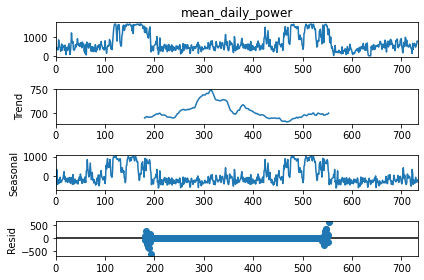

In [15]:
res = sm.tsa.seasonal_decompose(df_train['mean_daily_power'],
                                period=360,model="additive")
fig = res.plot()

In [17]:
X_train, X_test = df_train['mean_daily_power'][:719],\
                    df_train['mean_daily_power'][719:]

# ARIMA Model

In [17]:
def cross_val_arima(X, forecast_size, folds, P, D, Q):
    best = float('inf')
    for p in tqdm(range(P)):
        for d in range(D):
            for q in range(Q):
                rmse_list = []
                for i in range(folds):
                    train_size = len(X) - forecast_size * (folds-i)
                    X_train, X_val = X[:train_size], np.array(\
                        X[train_size:train_size+forecast_size])
                    model = ARIMA(X_train, order=(p,d,q))
                    res = model.fit()
                    y_hat = np.array(res.forecast(forecast_size))   
                    rmse = np.sqrt(skmetrics.mean_squared_error(\
                        X_val, y_hat))
                    rmse_list.append(rmse)
                avg = np.array(rmse_list).mean()
                if avg < best:
                    best = avg
                    features = (p,d,q)
    return best, features

In [19]:
best_arima_rmse, arima_features = cross_val_arima(\
    X_train, 15, 10, 4, 3, 4)

100%|█████████████████████████████████████████████| 4/4 [01:21<00:00, 20.39s/it]


In [20]:
print(f'''The best RMSE among
the validation was
{best_arima_rmse} with ARIMA{arima_features}.''')

The best RMSE among
the validation was
211.58760436865 with ARIMA(0, 1, 3).


In [21]:
model_1 = ARIMA(X_train, order=(0,1,3)).fit()
y_hat_1 = model_1.forecast(15)
test_rmse_1 = np.sqrt(skmetrics.mean_squared_error(\
                        X_test, y_hat_1))
print(f'The test RMSE for ARIMA{arima_features}is {test_rmse_1}.')

The test RMSE for ARIMA(0, 1, 3)is 178.08630729758502.


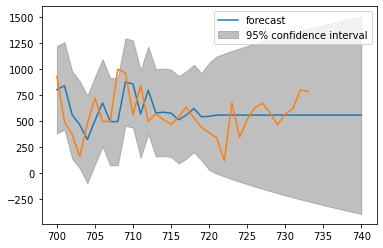

In [22]:
plot_predict(model_1, 700, 740)
plt.plot(df_train['mean_daily_power'][700:])
plt.show()

# Prophet Model

In [11]:
df_prophet = df_train[['Date', 'mean_daily_power']].copy()
df_prophet.columns = ['ds', 'y']
df_prophet.tail()

,ds,y
729,2020-03-11,466.289248
730,2020-03-12,570.315539
731,2020-03-13,619.637333
732,2020-03-14,800.312824
733,2020-03-15,787.305117


In [12]:
P_train, P_test = df_prophet[:719], df_prophet[719:]

In [13]:
#Prophet project
m = Prophet(changepoint_range=0.1, changepoint_prior_scale=.02)

m.add_seasonality(name='daily', period=345, fourier_order=55)
m.fit(P_train)
#Fataframe with forecasting steps
future = m.make_future_dataframe(periods=15)
#Forecast
forecast = m.predict(future)
forecast[['ds', 'yhat']].tail()

17:26:37 - cmdstanpy - INFO - Chain [1] start processing
17:26:37 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat
729,2020-03-11,543.893703
730,2020-03-12,582.590989
731,2020-03-13,564.643132
732,2020-03-14,600.331301
733,2020-03-15,595.044918


In [14]:
y_hat = forecast['yhat'][-15:]
test_rmse_2 = np.sqrt(skmetrics.mean_squared_error(P_test['y'], y_hat))
print(f'''The test RMSE for the Prophet model is
{test_rmse_2}.''')

The test RMSE for the Prophet model is
139.35284463516476.


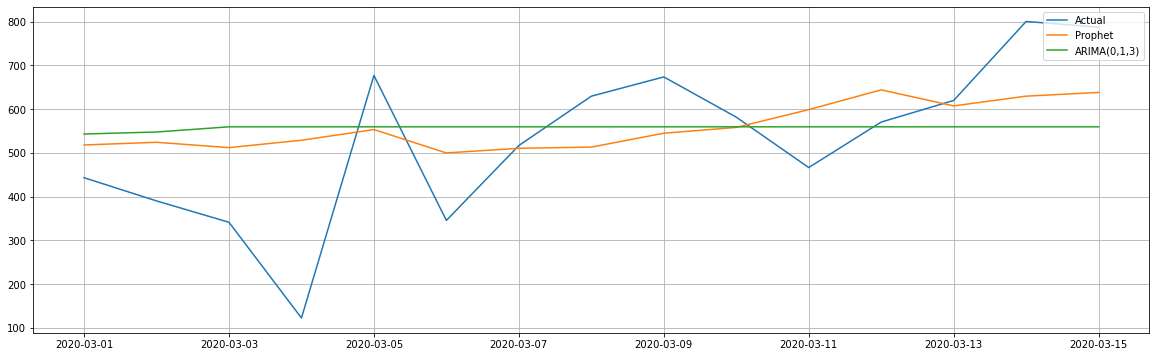

In [27]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(P_test['ds'], P_test['y'], label = 'Actual')
ax.plot(forecast['ds'][-15:], forecast['yhat'][-15:], label='Prophet')
ax.plot(P_test['ds'], y_hat_1, label='ARIMA(0,1,3)')
ax.grid()
ax.legend(loc='upper right')
plt.show()

# SARIMA Model

In [176]:
def rand_params(d_range, pq_range, m_range):
    p, q, P, Q = random.randint(pq_range[0], pq_range[1]),\
                random.randint(pq_range[0], pq_range[1]),\
                random.randint(pq_range[0], pq_range[1]),\
                random.randint(pq_range[0], pq_range[1])
    d, D = random.randint(d_range[0], d_range[1]),\
            random.randint(d_range[0], d_range[1])
    m = random.randint(m_range[0], m_range[1])
    return p, d, q, P, D, Q, m

In [263]:
def cross_val_sarima(X, forecast_size, folds, d_range = (0,2),
                    pq_range = (0,3), m_range=(0,10)):
    p,d,q,P,D,Q,m = rand_params(d_range, pq_range, m_range)
    rmse_list = []
    for i in range(folds):
        train_size = len(X) - forecast_size * (folds-i)
        X_train, X_val = X[:train_size], np.array(X[train_size:train_size+forecast_size])
        model = SARIMAX(X_train, order=(p,d,q),
                        seasonal_order=(P,D,Q,m), trend='ct')
        res = model.fit(disp=0)
        y_hat = np.array(res.forecast(forecast_size))   
        rmse = np.sqrt(skmetrics.mean_squared_error(X_val, y_hat))
        rmse_list.append(rmse)
    avg = np.array(rmse_list).mean()
    features = ((p,d,q), (P,D,Q,m))
    return avg, features

In [209]:
import time
def find_best_sarima(X, forecast_size, folds, d_range=(0,2),
                     pq_range=(0,4), m_range=(0,5), n_iter=100):
    start_time = time.time()
    best, features = float('inf'), None
    for i in tqdm(range(n_iter)):
        try:
            avg, feats = cross_val_sarima(X, forecast_size, folds,
                                         d_range, pq_range, m_range)
            if avg < best:
                best = avg
                features = feats
                print(f'Found SARIMA{features} with RMSE {avg}')
                print('------ %s seconds ------' % (time.time()-start_time))
        except:
            pass

    return best, features

In [210]:
best_sarima_rmse, sarima_features = find_best_sarima(
    X_train, 15, 5, d_range=(0,3), pq_range=(0,4),
    m_range=(0,10), n_iter=500)

  0%|                                       | 1/500 [01:47<14:54:33, 107.56s/it]

Found SARIMA((1, 1, 0), (4, 0, 4, 9)) with RMSE 313.24785561813735
------ 107.56779313087463 seconds ------


  1%|▎                                        | 4/500 [01:52<3:00:09, 21.79s/it]

Found SARIMA((0, 0, 3), (1, 1, 1, 4)) with RMSE 301.4680918731482
------ 112.90630340576172 seconds ------


  4%|█▌                                      | 20/500 [12:52<4:48:03, 36.01s/it]

Found SARIMA((2, 0, 0), (0, 0, 3, 2)) with RMSE 225.5492101285933
------ 772.8951122760773 seconds ------


 12%|████▊                                   | 60/500 [45:19<6:46:58, 55.50s/it]

Found SARIMA((2, 0, 2), (3, 0, 1, 7)) with RMSE 218.90446953765922
------ 2719.72105717659 seconds ------


 33%|████████████▎                        | 167/500 [2:52:44<2:50:24, 30.70s/it]

Found SARIMA((0, 0, 0), (3, 0, 0, 2)) with RMSE 212.7232303919603
------ 10364.558660268784 seconds ------


 41%|███████████████▏                     | 206/500 [5:06:54<4:03:06, 49.61s/it]

Found SARIMA((2, 0, 0), (4, 1, 1, 4)) with RMSE 212.20614508787577
------ 18414.6985912323 seconds ------


 53%|███████████████████▌                 | 264/500 [5:50:20<1:59:14, 30.31s/it]

Found SARIMA((0, 0, 2), (4, 0, 2, 5)) with RMSE 186.4915211335871
------ 21020.72089123726 seconds ------


100%|██████████████████████████████████████| 500/500 [10:39:41<00:00, 76.76s/it]


In [212]:
print(f'The best validation RMSE: {best_sarima_rmse} with SARIMA{sarima_features}')

The best validation RMSE: 186.4915211335871 with SARIMA((0, 0, 2), (4, 0, 2, 5))


In [47]:
sarima_model = SARIMAX(X_train, order=(6,0,0), seasonal_order=(0,0,0,12), trend='ct').fit(disp=0)
sarima_pred = sarima_model.forecast(15)
sarima_rmse = np.sqrt(skmetrics.mean_squared_error(X_test, sarima_pred))
print(f'Test RMSE for SARIMA model: {sarima_rmse}')

Test RMSE for SARIMA model: 172.87062968603107


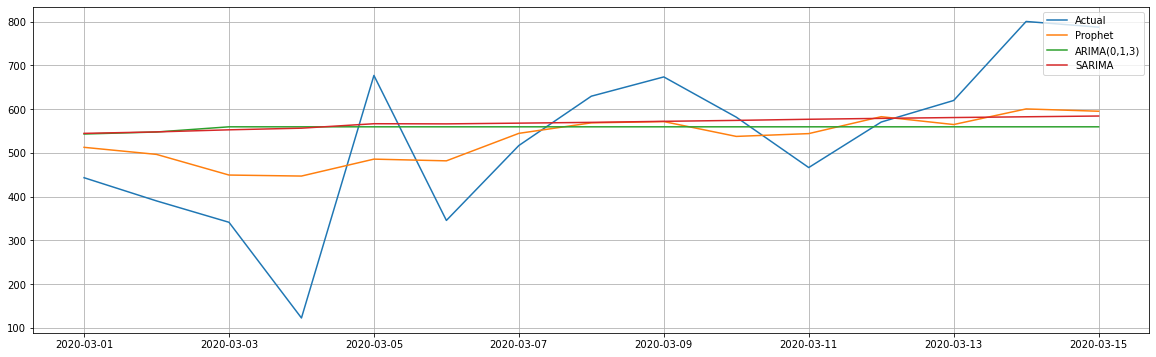

In [48]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(P_test['ds'], P_test['y'], label = 'Actual')
ax.plot(forecast['ds'][-15:], forecast['yhat'][-15:], label='Prophet')
ax.plot(P_test['ds'], y_hat_1, label='ARIMA(0,1,3)')
ax.plot(P_test['ds'], sarima_pred, label='SARIMA')
ax.grid()
ax.legend(loc='upper right')
plt.show()

# ETS Model

In [15]:
def find_ets(X, forecast_size, folds, season_iter):
    best, season = float('inf'), None
    for s in tqdm(range(2, season_iter)):
        for damp in [True, False]:
            rmse_list = []
            for i in range(folds):
                train_size = len(X) - forecast_size * (folds-i)
                X_train, X_val = X[:train_size], np.array(X[train_size:train_size+forecast_size])
                model = ExponentialSmoothing(X_train, trend="add", seasonal="add", 
                               seasonal_periods=s, damped_trend=damp).fit()
                pred = model.forecast(forecast_size)
                rmse = np.sqrt(skmetrics.mean_squared_error(X_val, pred))
                rmse_list.append(rmse)
            avg = np.array(rmse_list).mean()
        
            if avg < best:
                best = avg
                season = s
                damper = damp
                print(f'Found RMSE {best} with seasonal param {season}, and damp {damper}')
    return best, season

In [18]:
best, season = find_ets(X_train, 15, 5, 100)

  0%|                                                    | 0/98 [00:00<?, ?it/s]

Found RMSE 285.5833957210863 with seasonal param 2, and damp True


  4%|█▊                                          | 4/98 [00:07<02:35,  1.65s/it]

Found RMSE 285.5832825577366 with seasonal param 6, and damp True


  9%|████                                        | 9/98 [00:15<02:29,  1.68s/it]

Found RMSE 269.0778989363281 with seasonal param 10, and damp False


 26%|██████████▉                                | 25/98 [00:39<01:48,  1.49s/it]

Found RMSE 265.8167452106678 with seasonal param 26, and damp False


 38%|████████████████▏                          | 37/98 [01:00<01:32,  1.52s/it]

Found RMSE 257.8217005342261 with seasonal param 38, and damp False


 39%|████████████████▋                          | 38/98 [01:01<01:30,  1.51s/it]

Found RMSE 245.73302095963786 with seasonal param 39, and damp False


 98%|██████████████████████████████████████████ | 96/98 [02:37<00:03,  1.59s/it]

Found RMSE 228.39225199825842 with seasonal param 98, and damp True


 99%|██████████████████████████████████████████▌| 97/98 [02:38<00:01,  1.60s/it]

Found RMSE 214.84785589394755 with seasonal param 98, and damp False


100%|███████████████████████████████████████████| 98/98 [02:40<00:00,  1.64s/it]


In [188]:
best

216.30795066852724

In [19]:
ets_model = ExponentialSmoothing(X_train, trend="add", seasonal="add", 
                               seasonal_periods=38, damped_trend=True).fit()
ets_pred = ets_model.forecast(15)
ets_rmse = np.sqrt(skmetrics.mean_squared_error(X_test, ets_pred))
print(f'Test RMSE for ETS model: {ets_rmse}')

Test RMSE for ETS model: 136.64021392320103


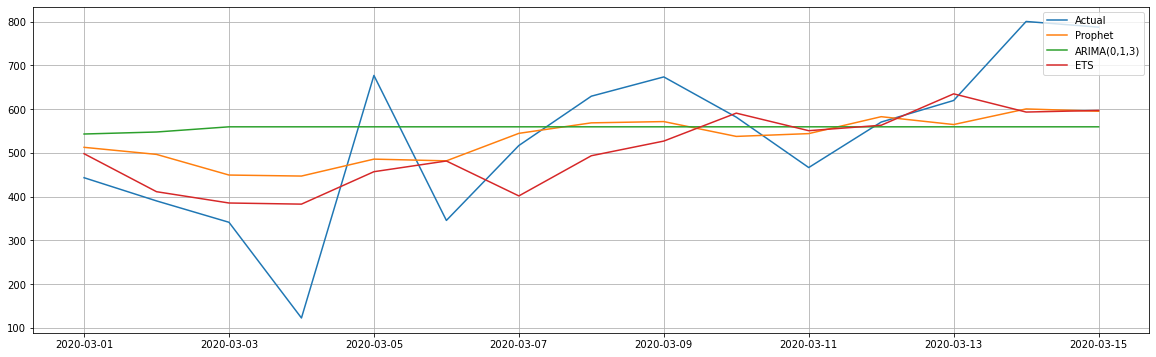

In [33]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(P_test['ds'], P_test['y'], label = 'Actual')
ax.plot(forecast['ds'][-15:], forecast['yhat'][-15:], label='Prophet')
ax.plot(P_test['ds'], y_hat_1, label='ARIMA(0,1,3)')
ax.plot(P_test['ds'], ets_pred, label='ETS')
ax.grid()
ax.legend(loc='upper right')
plt.show()

# Ensemble (ETS + Prophet) - Constructing Final Predictions

In [64]:
df_prophet

,ds,y
0,2018-01-01,366.223561
1,2018-01-02,462.550740
2,2018-01-03,454.417752
3,2018-01-04,369.952190
4,2018-01-05,319.446595
...,...,...
729,2020-03-11,466.289248
730,2020-03-12,570.315539
731,2020-03-13,619.637333
732,2020-03-14,800.312824


In [65]:
final_model = ExponentialSmoothing(df_prophet['y'], trend="add", seasonal="add", 
                               seasonal_periods=38, damped_trend=True).fit()
final_ets_pred = ets_model.forecast(15)

In [66]:
#Prophet project
m_final = Prophet(changepoint_range=0.1, changepoint_prior_scale=.02)

m_final.add_seasonality(name='daily', period=345, fourier_order=55)
m_final.fit(df_prophet)
#Fataframe with forecasting steps
future_final = m_final.make_future_dataframe(periods=15)
#Forecast
forecast_final = m_final.predict(future_final)
forecast_final[['ds', 'yhat']].tail()

20:12:28 - cmdstanpy - INFO - Chain [1] start processing
20:12:28 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat
744,2020-03-26,837.612153
745,2020-03-27,825.558472
746,2020-03-28,802.848853
747,2020-03-29,698.537485
748,2020-03-30,601.564830


In [67]:
final_prophet_pred = forecast_final['yhat'][-15:]
final_prophet_pred

734    641.675594
735    598.080004
736    618.041729
737    693.348138
738    696.789303
739    735.405581
740    713.598556
741    686.466453
742    670.741409
743    734.501203
744    837.612153
745    825.558472
746    802.848853
747    698.537485
748    601.564830
Name: yhat, dtype: float64

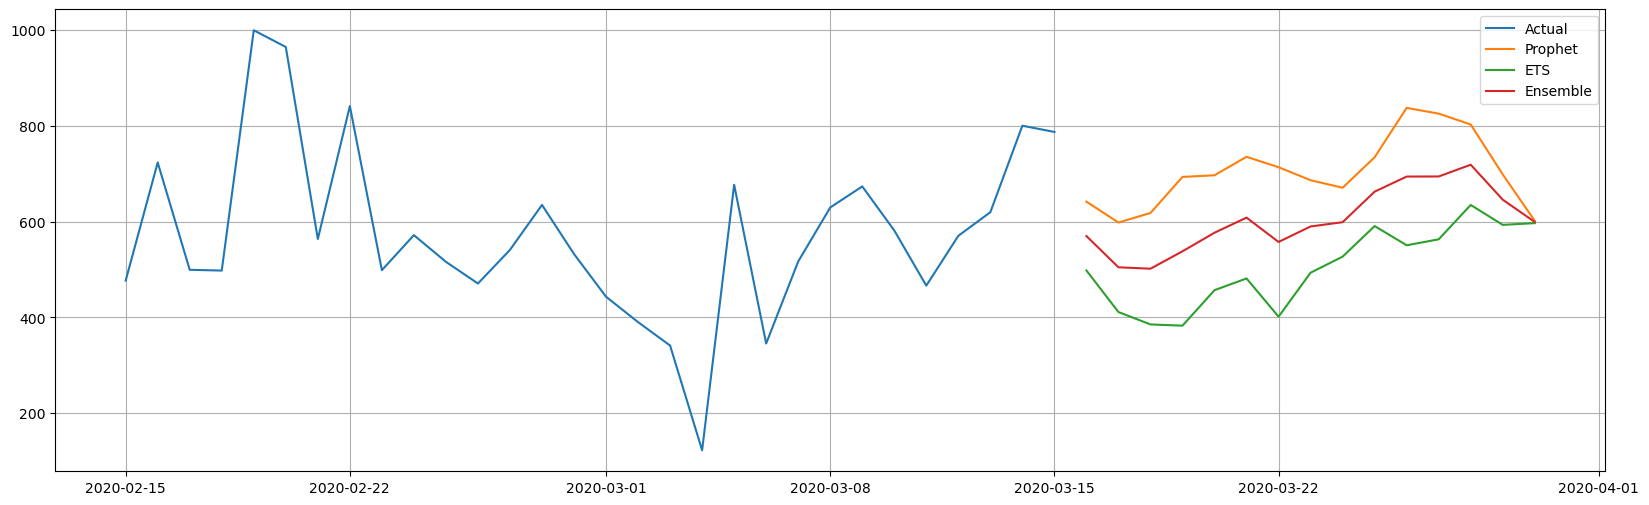

In [68]:
ensemble_final = (np.array(final_ets_pred) + np.array(final_prophet_pred)) / 2
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(df_prophet['ds'][-30:], df_prophet['y'][-30:], label = 'Actual')
ax.plot(forecast_final['ds'][-15:], forecast_final['yhat'][-15:], label='Prophet')
ax.plot(forecast_final['ds'][-15:], final_ets_pred, label='ETS')
ax.plot(forecast_final['ds'][-15:], ensemble_final, label='Ensemble')
ax.grid()
ax.legend(loc='upper right')
plt.show()

In [69]:
final = forecast_final[['ds', 'yhat']][-15:].copy()

In [70]:
final['yhat'] = ensemble_final
final = final.reset_index(drop=True)
final.columns = ['Date', 'Forecastings']
final

,Date,Forecastings
0,2020-03-16,569.824981
1,2020-03-17,504.574988
2,2020-03-18,501.636895
3,2020-03-19,538.002682
4,2020-03-20,576.800307
5,2020-03-21,608.344257
6,2020-03-22,557.504331
7,2020-03-23,589.876732
8,2020-03-24,598.783171
9,2020-03-25,662.599874


In [71]:
final.to_csv('predictions_final.csv', index=False)

In [20]:
ensemble = (np.array(forecast['yhat'][-15:]) + np.array(ets_pred))/2

In [21]:
P_test['ensemble'] = ensemble
final = P_test.copy()
final = final.drop(columns = 'y')

In [75]:
final.head()

,Date,Forecastings
0,2020-03-16,569.824981
1,2020-03-17,504.574988
2,2020-03-18,501.636895
3,2020-03-19,538.002682
4,2020-03-20,576.800307


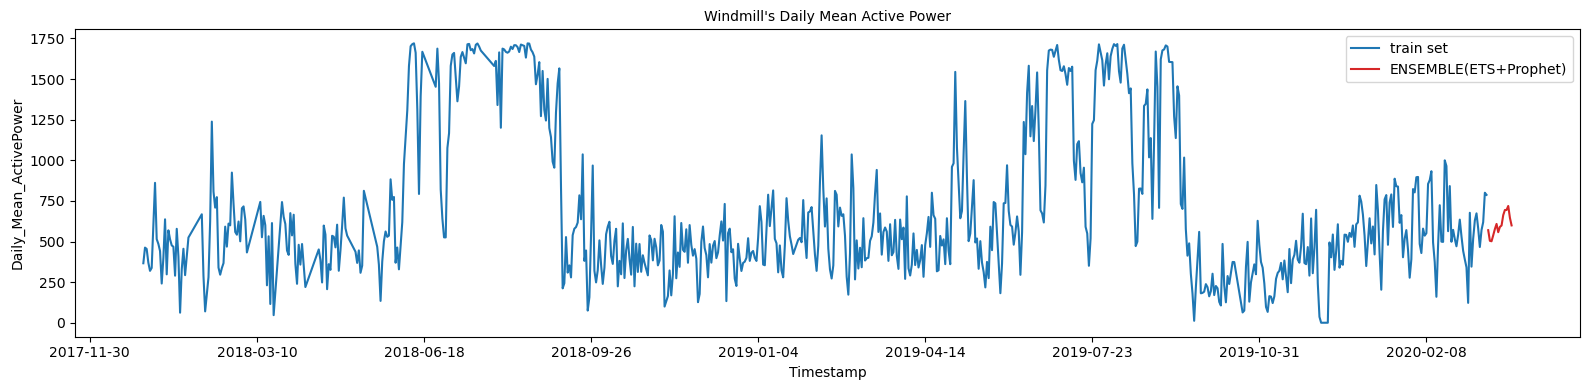

In [78]:
nrows, ncols = 1, 1
fig, ax = plt.subplots(nrows, ncols, figsize=(16,4))

ax1 = plt.subplot(nrows, ncols, 1)
ax1.plot(df_prophet['ds'].values, df_prophet['y'].values, c='tab:blue', label = 'train set')
# ax1.plot(P_test['ds'].values, P_test['y'].values, c='tab:orange', label = 'test set')
ax1.plot(final['Date'].values, final['Forecastings'].values, c='tab:red', label = 'ENSEMBLE(ETS+Prophet)')
ax1.xaxis.set_major_locator(plt.MaxNLocator(10))
ax1.set_ylabel('Daily_Mean_ActivePower')
ax1.set_xlabel('Timestamp')
ax1.set_title("Windmill's Daily Mean Active Power", fontsize=10)
ax1.legend()
plt.tight_layout()
plt.show()

In [ ]:
final.to_csv('predictions.csv')

#### Exploring with other features

In [26]:
P_train.head()

,ds,y,day,dayofweek,is_month_start,is_month_end,is_weekend
0,2018-01-01,366.223561,1,0,True,False,0
1,2018-01-02,462.550740,2,1,False,False,0
2,2018-01-03,454.417752,3,2,False,False,0
3,2018-01-04,369.952190,4,3,False,False,0
4,2018-01-05,319.446595,5,4,False,False,0


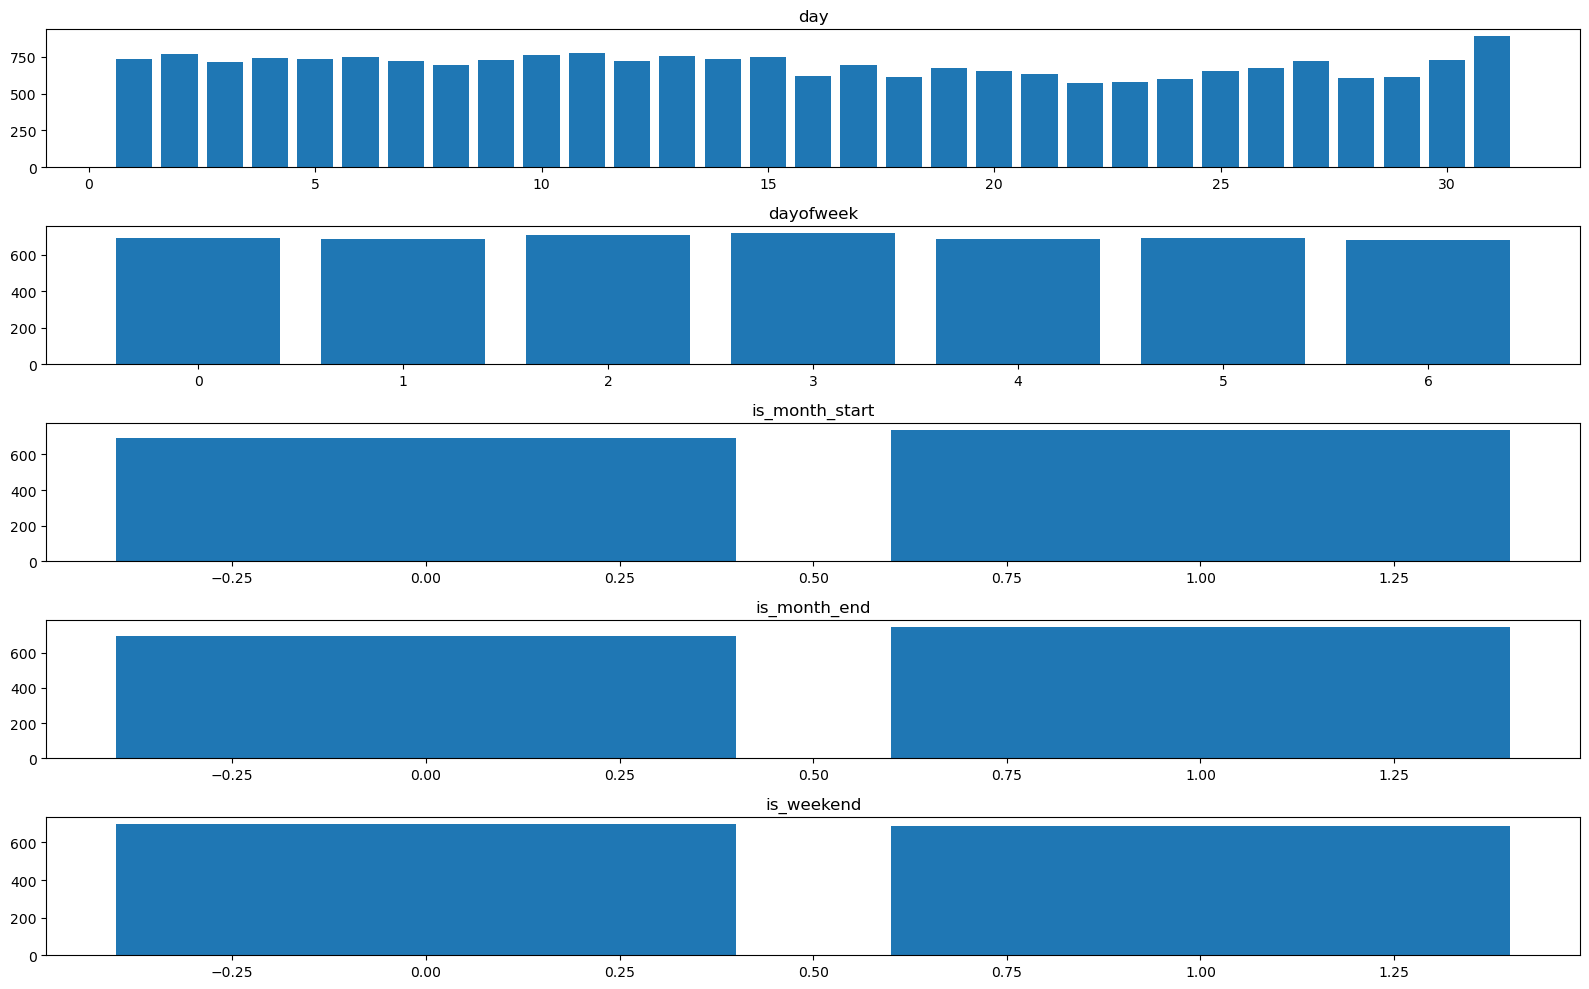

In [27]:
def add_timestamp_features(data):
    pd.options.mode.chained_assignment = None
    data['ds'] = pd.to_datetime(data['ds'])
    data['day'] = data['ds'].dt.day
    #data['hour'] = data['ds'].dt.hour
    data['dayofweek'] = data['ds'].dt.dayofweek
    data['is_month_start'] = data['ds'].dt.is_month_start
    data['is_month_end'] = data['ds'].dt.is_month_end

    conditions = [(data['dayofweek'].eq(5) | data['dayofweek'].eq(6))]
    choices = [1]
    data['is_weekend'] = np.select(conditions, choices, default=0)
    return data

train = add_timestamp_features(P_train)

nrows, ncols = 5,1 
fig, ax = plt.subplots(nrows, ncols, figsize=(16,10))

for i, col in enumerate(['day','dayofweek','is_month_start','is_month_end','is_weekend']):
    
    plot_data = train.groupby(col)['y'].mean()
    
    cax = plt.subplot(nrows, ncols, i+1)
    cax.bar(plot_data.index, plot_data.values)
    # Need to add automatic adding of labels of x-axis
    cax.set_title('{}'.format(col, fontsize=10))

plt.tight_layout()
plt.show()

pd.options.mode.chained_assignment = 'warn'

In [41]:
valid = add_timestamp_features(P_test)
valid.rename(columns = {'ensemble':'y'}, inplace = True)

In [42]:
train['AmbientTemperature'] = df['AmbientTemperatue'].iloc[:-15]
valid['AmbientTemperature'] = df['AmbientTemperatue'].iloc[-15:]

In [43]:
import lightgbm as lgb

x_train, y_train = train.drop(columns=['y','AmbientTemperature' ]), train['y'].values
x_valid, y_valid = valid.drop(columns=['y', 'AmbientTemperature']), valid['y'].values

params = {'num_leaves': 30,
          'n_estimators': 1000,
          'max_depth': 8,
          'min_child_samples': 1000,
          'learning_rate': 0.25,
          'subsample': 0.70,
          'colsample_bytree': 0.75
         }

model = lgb.LGBMRegressor(**params)
model = model.fit(x_train.drop(columns=['ds']), y_train)

In [51]:
valid_preds = model.predict(x_valid.drop(columns=['ds']))   
valid_preds
y_valid[:,0]

array([443.05849616, 390.02736114, 341.13355979, 122.34895704,
       676.89315087, 345.37983561, 516.6749624 , 629.44713258,
       673.51900205, 581.53262984, 466.28924766, 570.31553859,
       619.63733277, 800.31282383, 787.30511737])

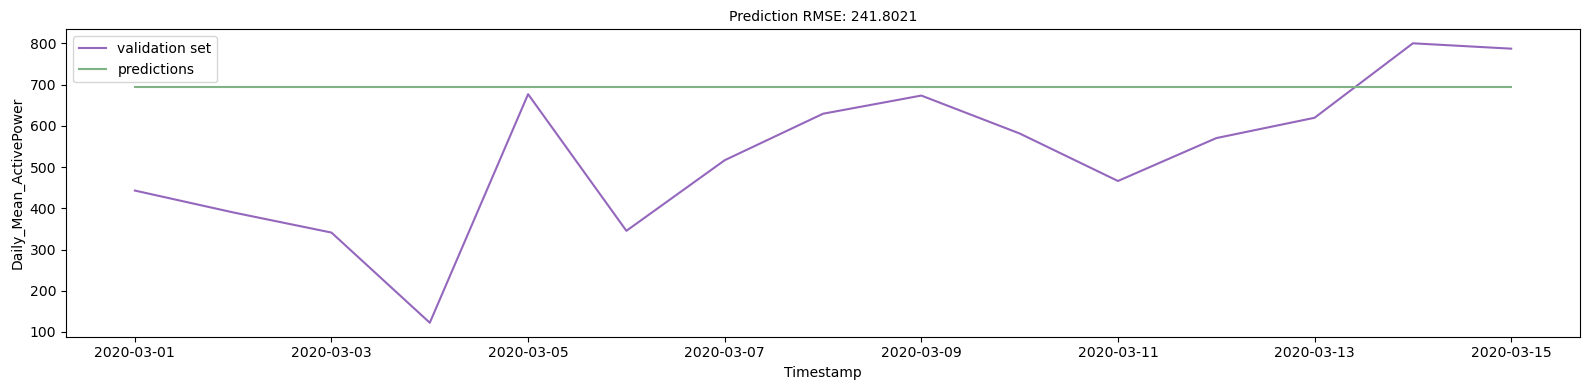

In [54]:
def plot_predictions(x_valid, y_valid, valid_preds):
    
    rmse = skmetrics.mean_squared_error(y_valid[:,0], valid_preds, squared=False)
    
    nrows, ncols = 1, 1
    fig, ax = plt.subplots(nrows, ncols, figsize=(16,4))

    ax1 = plt.subplot(nrows, ncols, 1)
    ax1.plot(x_valid['ds'].values, y_valid[:,0], c='tab:purple', label = 'validation set')
    ax1.plot(x_valid['ds'].values, valid_preds, c='#7FB285', label = 'predictions')
    ax1.set_ylabel('Daily_Mean_ActivePower')
    ax1.set_xlabel('Timestamp')
    ax1.xaxis.set_major_locator(plt.MaxNLocator(10))
    ax1.set_title('Prediction RMSE: {:.4f}'.format(rmse), fontsize=10)
    ax1.legend()
    plt.tight_layout()
    plt.show()
    
valid_preds = model.predict(x_valid.drop(columns=['ds']))    
plot_predictions(x_valid, y_valid, valid_preds)


####  <font color='blue'> We tried moldels following models -  ARIMA, SARIMA, PROHET, ETS , Emsemble(ETS+Prophet). Amongst all the models, Ensemble (ETS+Prophet) is our final model.